In [1]:
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [2]:
% matplotlib inline
import pylab as plt 
import numpy as np
from sklearn.metrics import roc_auc_score

def plot_cumulative_score(smod, pos_seqs, sequence_length=None, motif_length=None):
    sig = None
    for scores in smod.score(pos_seqs):
        if sig is None:
            sig = np.array(scores)
        else:
            sig += np.array(scores)
    sig=np.array(sig)
    
    truth = np.zeros(len(sig))
    truth[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2]=1
    roc = roc_auc_score(truth, sig)
    print 'ROC: %.2f' % roc


    plt.figure(figsize=(16,3))
    sigp = np.copy(sig)
    sigp[sigp<0]=0
    plt.bar(range(len(sigp)), sigp, alpha=0.3, color='g')
    sign = np.copy(sig)
    sign[sign>=0]=0
    plt.bar(range(len(sign)), sign, alpha=0.3, color='r')
    plt.plot((sequence_length/2-motif_length/2, sequence_length/2-motif_length/2), (min(sig), max(sig)), 'k-', lw=4)
    plt.plot((sequence_length/2+motif_length/2, sequence_length/2+motif_length/2), (min(sig), max(sig)), 'k-', lw=4)
    plt.xticks(range(len(sig)))
    plt.grid()
    plt.show()

In [3]:
#code for making artificial dataset
import random
import  numpy as np

def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,perturbation_prob=0.5):
    seq=''
    for c in seed:
        if random.random() < perturbation_prob: 
            c = random.choice(alphabet_list)
        seq += c
    return seq

def create_motives(alphabet='ACGU', motif_length=10):
    motives = []
    for character in alphabet:
        motif = [character]*motif_length
        motives.append(''.join(motif))
    return motives

def make_artificial_dataset(alphabet='ACGU', 
                            motif_length=10,
                            sequence_length=100, 
                            n_sequences=1000, 
                            n_motives=2, 
                            perturbation_prob=0.2):
    alphabet_list=[c for c in alphabet]
    motives = [random_string(motif_length, alphabet_list) for i in range(n_motives)]
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    targets=[]
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,perturbation_prob)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('ID_%.3d'%counter,seq))
            targets.append(j)
            counter += 1
    return seqs, np.array(targets), motives

In [4]:
def make_experiment(complexity=3,
                    motif_length=10,
                    n_motives=2,
                    sequence_length=30,
                    n_sequences=1001,
                    perturbation_prob=0.3,
                    min_score=4,
                    min_freq=0.6,
                    min_cluster_size=10):
    pos_seqs, targets, motives = make_artificial_dataset('ACGU',
                                                         motif_length,
                                                         sequence_length,
                                                         n_sequences,
                                                         n_motives,
                                                         perturbation_prob)
    
    from eden.modifier.seq import seq_to_seq, shuffle_modifier
    neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=1, order=2)


    
    n_clusters=n_motives*2
    min_subarray_size=motif_length-motif_length/3
    max_subarray_size=motif_length+motif_length/3
    block_size=n_sequences/8

    print 'motif_length:',motif_length
    print 'n_motives:',n_motives
    print 'sequence_length:',sequence_length
    print 'n_sequences:',n_sequences
    print 'perturbation_prob:',perturbation_prob
    print
    print 'n_clusters:',n_clusters
    print 'min_subarray_size:',min_subarray_size
    print 'max_subarray_size:',max_subarray_size
    print 'block_size:',block_size
    print
    print 'min_score:',min_score
    print 'min_freq:',min_freq
    print 'min_cluster_size:',min_cluster_size
    print
    for motif in motives: print motif
    print

    from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
    smod=SMoD(complexity=complexity,
              n_clusters=n_clusters,
              min_subarray_size=min_subarray_size,
              max_subarray_size=max_subarray_size,
              pos_block_size=block_size,
              neg_block_size=block_size)
    smod = smod.fit(pos_seqs, neg_seqs)
    plot_cumulative_score(smod, pos_seqs, sequence_length=sequence_length, motif_length=motif_length)
    clusters = smod.predict(pos_seqs)
    motives = smod.compute_motives(clusters,
                                   min_score=min_score,
                                   min_freq=min_freq,
                                   min_cluster_size=min_cluster_size)
    logos = smod.display_logos(motives)

---

motif_length: 8
n_motives: 3
sequence_length: 80
n_sequences: 600
perturbation_prob: 0.2

n_clusters: 6
min_subarray_size: 6
max_subarray_size: 10
block_size: 75

min_score: 5
min_freq: 0.65
min_cluster_size: 10

GCACUAGG
GAGUCAAG
GACGGCGG

ROC: 1.00


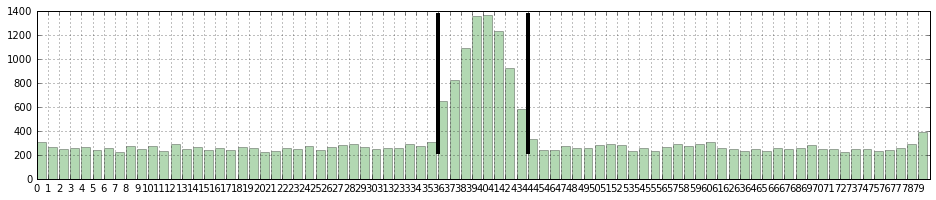

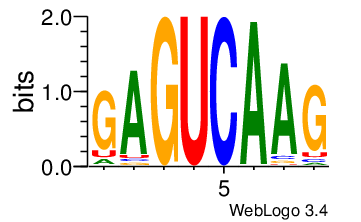

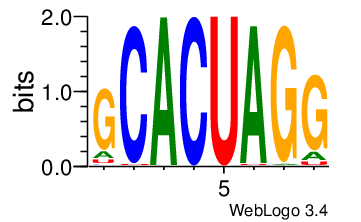

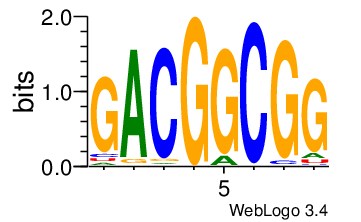

CPU times: user 8.64 s, sys: 692 ms, total: 9.33 s
Wall time: 1min 6s


In [8]:
%%time
make_experiment(complexity=5,
                motif_length=8,
                n_motives=3,
                sequence_length=80,
                n_sequences=600,
                perturbation_prob=0.2,
                min_score=5,
                min_freq=0.65,
                min_cluster_size=10)

---